### Распаковка архива данных

In [1]:
pwd

'C:\\Users\\Andrey\\Downloads\\Text_Recognition'

In [2]:
!tar -xzf lines_w25.tar.gz 

### Загрузка библиотек

In [3]:
import os
import cv2
from pathlib import Path
import glob
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

### Сохранение имен файлов

In [4]:
path = Path('lines_w25')

names = sorted([image.split(os.path.sep)[-1].split('.png')[0] for image in list(map(str, list(path.glob("*.png"))))])
print(names[:5])

['0_a', '0_b', '100000_a', '100000_b', '10000_a']


### Просмотр данных

весть.: мид еще раз напом


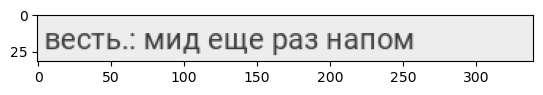

In [5]:
image = names[0] + ".png"
text = names[0] + ".gt.txt"

with open(os.path.join(path, text), 'r', encoding='utf-8') as f:
    print(f.read().strip('\n'))
image = io.imread(os.path.join(path, image))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

### Установка размеров изображения, размера батча.
### Функция преобразования текста в числовой формат.


In [6]:
WIDTH = 25
batch_size = 128
img_width = 340
img_height = 32

def text_to_numbers(name):
    text = os.path.join(path, name + ".gt.txt")
    with open(text, 'r', encoding='utf-8') as f:
        label = f.read().strip("\n")
    missing_chars = WIDTH - len(label)
    if missing_chars > 0:
        label += ' ' * missing_chars
    return label

### Создаем 3 списка данных: пути к изображениям, целевые метки, уникальные символы

In [7]:
images = np.array([os.path.join(path, name + ".png") for name in names])
labels = np.array([text_to_numbers(name) for name in names])
characters = set(char for label in labels for char in label)

print(len(images))
print(len(labels))

200001
200001


### Преобразование данных

In [8]:
# Преобразование символов в целые числа
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=1, mask_token=None
)

# Преобразование целых чисел обратно в исходные символы
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Полный размер датасета
    size = len(images)
    # 2. Создание списка индексов и перемешивание их, если требуется
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Получение списка тренировочных сэмплов 
    train_samples = int(size * train_size)
    # 4. Разделение данных на тренировочный и валидационный сеты
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Разделение данных на тренировочный и валидационный сеты
x_train, x_valid, y_train, y_valid = split_data(images, labels)


def encode_single_sample(img_path, label):
    # 1. Чтение данных
    img = tf.io.read_file(img_path)
    # 2. Преобразование каналов изображений
    img = tf.io.decode_png(img, channels=1)
    # 3. Преобразование в float32 в диапазоне [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Обрезка изображения до желаемого размера
    img = tf.image.resize(img, [img_height, img_width])
    print(img)
    # 5. Транспонирование изображения
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Преобразование символьных значенией в числовые
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

### Создание Dataset Objects

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

Tensor("resize/Squeeze:0", shape=(32, 340, 1), dtype=float32)
Tensor("resize/Squeeze:0", shape=(32, 340, 1), dtype=float32)


### Визуализация данных

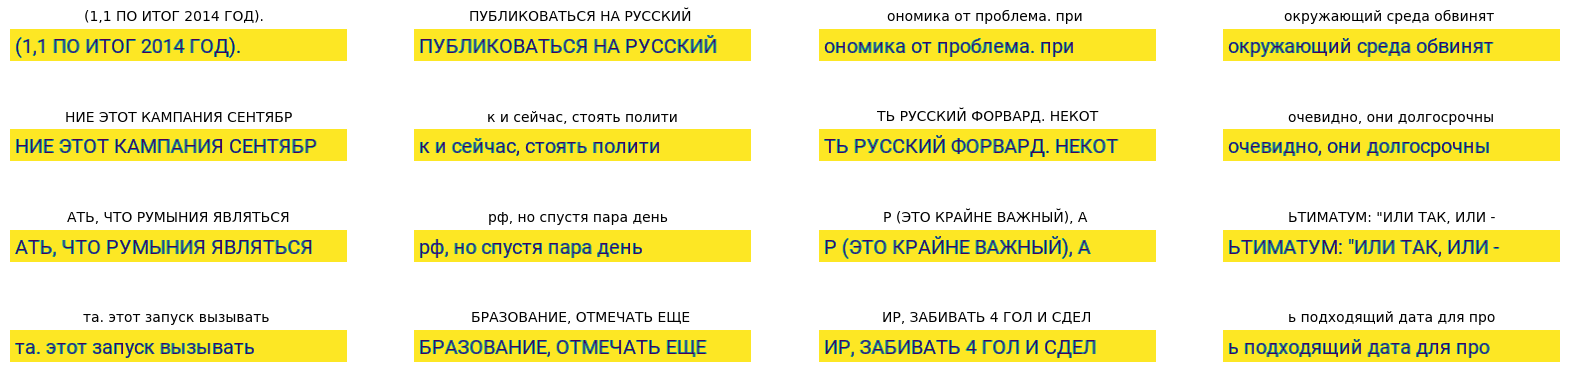

In [10]:
fig, ax = plt.subplots(4, 4, figsize=(20, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T)
        ax[i // 4, i % 4].set_title(label, fontdict={'fontsize': 10})
        ax[i // 4, i % 4].axis("off")
plt.show()

### Создаем модель

In [11]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    # Вход для модели
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Первый сверточный слой
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Второй сверточный слой
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Меняем форму соответствующим образом перед передачей 
    # выходных данных в RNN слои
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNN слои
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Выходной слой
    x = layers.Dense(len(characters) + 2, activation="softmax", name="dense2")(x)

    # Добавление CTC layer для вычисления CTC loss на каждом шаге
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Определяем модели
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Оптимизатор
    opt = keras.optimizers.Adam()
    # Компиляция модели
    model.compile(optimizer=opt)
    return model


model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 340, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 340, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 170, 16, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 170, 16, 64)  18496       ['pool1[0][0]']       

In [12]:
# !pip install livelossplot
# from livelossplot.tf_keras import PlotLossesCallback

### Тренировка модели

In [14]:
epochs = 100
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/10
1407/1407 [==============================] - 1015s 716ms/step - loss: 37.1788 - val_loss: 1.0281
Epoch 2/10
1407/1407 [==============================] - 885s 629ms/step - loss: 1.0353 - val_loss: 0.3332
Epoch 3/10
1407/1407 [==============================] - 892s 634ms/step - loss: 0.4834 - val_loss: 0.1833
Epoch 4/10
1407/1407 [==============================] - 900s 640ms/step - loss: 0.2944 - val_loss: 0.1166
Epoch 5/10
1407/1407 [==============================] - 886s 630ms/step - loss: 0.1988 - val_loss: 0.0748
Epoch 6/10
1407/1407 [==============================] - 885s 629ms/step - loss: 0.1363 - val_loss: 0.0431
Epoch 7/10
1407/1407 [==============================] - 881s 626ms/step - loss: 0.1003 - val_loss: 0.0330
Epoch 8/10
1407/1407 [==============================] - 884s 628ms/step - loss: 0.0819 - val_loss: 0.0313
Epoch 9/10
1407/1407 [==============================] - 883s 627ms/step - loss: 0.0722 - val_loss: 0.0250
Epoch 10/10
1407/1407 [=====================

4/4 [==============================] - 1s 75ms/step


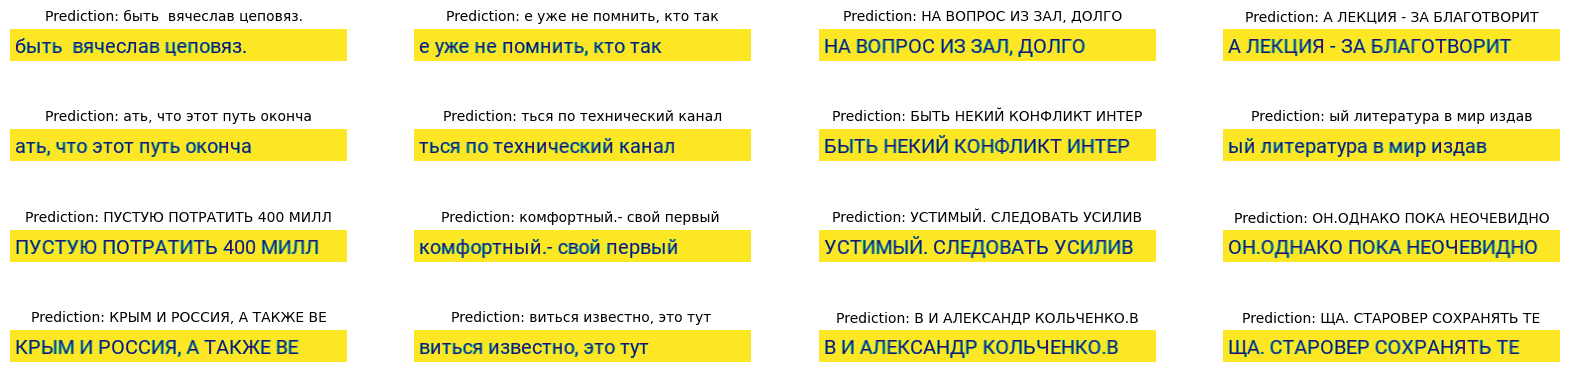

In [329]:

prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# Функция для декодирования выхода сети
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Используем greedy search. Для сложных задач можно использовать beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :WIDTH
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Проверка результатов на валидационном сете
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    fig, ax = plt.subplots(4, 4, figsize=(20, 5))
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(title, fontdict={'fontsize': 10})
        ax[i // 4, i % 4].axis("off")
plt.show()

### Используем модуль pytesseract для детектирования текста


In [13]:
import pytesseract
import shutil
import os
import random

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
print(pytesseract.get_languages(config=''))

['eng', 'enm', 'osd', 'rus']


In [14]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

class Extract:
    def __init__(self, image):
        self.__image = image
        self.__data = None
        
    # извлекаем координаты детекций
    def extract_data(self):
        df = pd.DataFrame([x.split('\t') for x in pytesseract.image_to_data(Image.open(self.__image), lang='rus') \
                              .split('\n')])

        df = df.rename(columns=df.iloc[0]) \
                        .drop(df.index[0]) \
                        .replace('', np.nan) \
                        .dropna(subset=['text'])

        df.set_index(pd.Index(list(range(df.shape[0]))), inplace=True)
        df = df[df.columns[6:10]]
        df[df.columns] = df[df.columns].astype('int32')
        self.__data = df.copy()
        return self.__data

    # изображение с детекциями
    def show_image(self):
        
        assert self.__data is not None, "Примените функцию 'extract_data' для извлечения данных"
        
        image = cv2.imread(self.__image, cv2.IMREAD_COLOR)
        b, g, r = cv2.split(image) # img b,g,r
        image = cv2.merge([r,g,b])

        for i in range(self.__data.shape[0]):
            left, top, width, height = self.__data.iloc[i, :4]
            image = cv2.rectangle(image, (left, top), (left+width, top+height), (255, 0, 0), 1)

        plt.figure(figsize=(10,10))
        plt.imshow(image)

### Создание батча изображений детекций с картинки

In [15]:
# сохранение списка файлов в текстовый файл
!dir /B > images.txt

In [16]:
# открытие сохраненного файла и фильтрация изображений
with open('images.txt',  'r') as f:
    files = f.read().split()

images = [image for image in files if ".jpeg" in image]
print(images)

['0.jpeg', '1.jpeg', '10.jpeg', '11.jpeg', '12.jpeg', '13.jpeg', '14.jpeg', '15.jpeg', '16.jpeg', '17.jpeg', '18.jpeg', '19.jpeg', '2.jpeg', '20.jpeg', '21.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg']


In [18]:
path = os.path.join(os.getcwd(), "Images")

if not os.path.exists(path):
    !mkdir Images

In [19]:
from PIL import Image

images_list = []

# загружаем одно изображение из списка
image = images[0]

# извлекаем координаты детекций с изображения
ex = Extract(image)
data = ex.extract_data()

# чтение файла
image = io.imread(image)

# вырезаем с изображения детекции для дальнейшнего распознавания текста
for enum, (left, top, width, height) in enumerate(data.values):
    im = image[top:top+height, left:left+width]
    if im.shape[0] > 0 and im.shape[1] > 0:
        im = Image.fromarray(im)
        im.save(f"C:/Users/Andrey/Downloads/Text_Recognition/Images/{enum}.png")
        images_list.append(f"Images/{enum}.png")

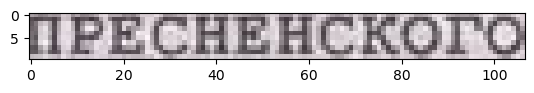

In [20]:
# пример изображения детекции
example = io.imread(images_list[5])
plt.imshow(example);

In [438]:
# создаем батч, равный количеству детекций, полученных с изображения
batch_size = len(images_list)

# создаем проверочный Dataset Object
test_dataset = tf.data.Dataset.from_tensor_slices((np.array(images_list), np.array([""]*batch_size)))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

# отправляем батч(все детекции) в метод predict модели
for batch in test_dataset.take(1):
    image = batch["image"]
    print(image.shape)
    pred = prediction_model.predict(image)
    
# декодируем выход сети
decode_batch_predictions(pred)

Tensor("resize/Squeeze:0", shape=(32, 340, 1), dtype=float32)
(34, 340, 32, 1)
2/2 [==============================] - 0s 26ms/step


['                         ',
 ' (                       ',
 '( 9(  ((( ( (* ( (у( ( 4 ',
 '; и  ) ) ) (;) , ) ) (;, ',
 'ч, ч   , уа   , , , у, иу',
 ' (  (* (уу  ( ; (уу уу; (',
 'у (у ( " (у (у; "(у  (у (',
 ' ([у-*     уууу,    , , у',
 'уу у чу , [уу[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 ',у, ч, ч   у   ч, ич  , и',
 '*4** ;  (у  (  ч  чу  ччу',
 '  х  .  ч     с ч1    ,  ',
 ' ч         у;    - - -   ',
 '  - - - -                ',
 '                         ',
 '                         ',
 '                 [UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '                       ч[UNK]',
 '                         ',
 '                1 1 1 1 1',
 '  1[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '                         ',
 '                         ',
 ' Й *     чч    ч-  ч  ч [UNK]',
 ' ), ) ч и  (угг, учу, ) (',
 '  у; и  чу , чч   у;ггг;у',
 '                    , , ,',
 '(    г      